**MODELADO**

**1. Librerías**

In [79]:
try:
  from google.colab import auth
  auth.authenticate_user()
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  from google.cloud import storage
  from googleapiclient.discovery import build
  from google.cloud import storage
  from sklearn.feature_extraction.text import TfidfVectorizer # Modelado
  from sklearn.model_selection import train_test_split, GridSearchCV # Modelado
  from sklearn.ensemble import GradientBoostingClassifier # Modelado
  from sklearn.linear_model import LogisticRegression # Modelado
  from sklearn.metrics import accuracy_score, confusion_matrix, classification_report # Metricas
except:
  !pip install google-cloud-storage
  !pip install pandas
  !pip install sklearn
  !pip install numpy
  !pip install matplotlib.pyplot

**2. Lectura de datos**

In [10]:
def descargar_de_bucket_origen(nombre_bucket_origen, nombre_blob_origen, nombre_archivo_destino):
    cliente = storage.Client()
    bucket = cliente.bucket(nombre_bucket_origen)
    blob = bucket.blob(nombre_blob_origen)
    blob.download_to_filename(nombre_archivo_destino)
    print(f"Archivo {nombre_blob_origen} descargado como {nombre_archivo_destino}.")

In [11]:
nombre_bucket_origen = 'ds-edw-processed-d1655b14'
nombre_bucket_procesado = 'ds-edw-processed-d1655b14'
nombre_blob_origen = 'CSV/df_processed.csv' # Aquí se pone el nombre de la carpeta CSV, barra / , y el nombre del csv con el que queremos trabajar
ruta_descarga_local = 'df_processed.csv' # Aquí se pone solamente el nombre del csv con el que queremos trabajar
descargar_de_bucket_origen(nombre_bucket_origen, nombre_blob_origen, ruta_descarga_local)

Archivo CSV/df_processed.csv descargado como df_processed.csv.


In [12]:
data = pd.read_csv(ruta_descarga_local)
data.head()

,label,processed_text
0,0,arco forum recibe este viernes la medalla de o...
1,0,las reacciones a la muerte de chacon de todo s...
2,0,millones de chilenos no votan nunca otros tant...
3,0,dime a mi y yo te hago reir com osea para que ...
4,0,se compraron esas aireadoras culias de papas f...


**3. División de datos**

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    data['processed_text'],
    data['label'],
    train_size=0.75,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

Comprobamos que ambos conjuntos de train tienen los datos que han de tener.

In [14]:
X_train.iloc[:10]

9480     choco un video aficionado registro un angustio...
22396        toneladas de inmigrantes musulmanes africanos
20199                              gilipollez progre macho
1373     con justa razon esas canciones que mujer mas b...
14364    habla como chileno antes de irte culiao weon l...
14669    recambio en equipo de chanta expertos ingresa ...
9406     dices que sois la solucion para todos los cata...
1135     un poquito de por favor los indigenas al igual...
22136                                 mentirosos populares
426      en cataluna ha ganado la derecha la independen...
Name: processed_text, dtype: object

In [15]:
y_train.iloc[:10]

9480     0
22396    1
20199    1
1373     0
14364    1
14669    1
9406     0
1135     0
22136    1
426      0
Name: label, dtype: int64

**4. Entrenamiento del modelo**

Vamos a descartar las palabras que aparecen en más del 95% de los documentos, términos muy comunes, y las que aparecen en menos de 3 documentos, términos muy raros.


In [16]:
cv = TfidfVectorizer(
    max_df=0.95,
    min_df=3,
    max_features = 2500,
    ngram_range=(1, 1)
)
cv.fit(X_train)

TfidfVectorizer(max_df=0.95, max_features=2500, min_df=3)

In [17]:
print(list(cv.vocabulary_.items())[:60])

[('un', 2321), ('video', 2417), ('en', 688), ('las', 1186), ('de', 524), ('este', 765), ('migrante', 1397), ('su', 2156), ('bebe', 182), ('fueron', 874), ('por', 1794), ('la', 1174), ('rio', 1995), ('inmigrantes', 1110), ('musulmanes', 1470), ('africanos', 37), ('progre', 1834), ('macho', 1282), ('con', 403), ('razon', 1936), ('esas', 726), ('que', 1893), ('mujer', 1459), ('mas', 1333), ('bella', 184), ('habla', 958), ('como', 387), ('chileno', 325), ('antes', 97), ('culiao', 496), ('weon', 2480), ('wea', 2477), ('equipo', 717), ('mapuche', 1318), ('estuvo', 780), ('tv', 2306), ('pase', 1653), ('ver', 2395), ('lo', 1260), ('grave', 937), ('puso', 1881), ('duda', 655), ('sea', 2054), ('dice', 597), ('se', 2053), ('sale', 2030), ('muerto', 1456), ('paso', 1655), ('miserable', 1418), ('dices', 599), ('sois', 2140), ('solucion', 2146), ('para', 1623), ('todos', 2253), ('los', 1269), ('catalanes', 290), ('pero', 1716), ('una', 2322), ('sola', 2142), ('palabra', 1606)]


In [18]:
X_train_ = cv.transform(X_train)
X_test_ = cv.transform(X_test)

Vamos a utilizar un modelo de regresión logística y un gradient boosting.

In [19]:
# Diferentes parámetros de C
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10,100]}

# Inicializar el clasificador de regresión logística
lr = LogisticRegression(solver='lbfgs', max_iter=500)

# Inicializar GridSearchCV
grid_search = GridSearchCV(lr, param_grid, cv=5, scoring='accuracy')

# Entrenar GridSearchCV
grid_search.fit(X_train_, y_train)

# Obtener el mejor valor de C
best_C = grid_search.best_params_['C']
print("Mejor valor de C:", best_C)

Mejor valor de C: 5


In [20]:
# Inicializar un nuevo clasificador de regresión logística con el mejor valor de C
best_lr = LogisticRegression(C=best_C, solver='lbfgs', max_iter=500)

# Entrenar el modelo con los datos de entrenamiento
best_lr.fit(X_train_, y_train)

# Predecir las etiquetas
y_train_pred = best_lr.predict(X_train_)
y_test_pred = best_lr.predict(X_test_)

# Calcular el accuracy del modelo
accuracy_train_lr = accuracy_score(y_train, y_train_pred)
accuracy_test_lr = accuracy_score(y_test, y_test_pred)
print("Accuracy en train: {:.4f}".format(accuracy_train_lr))
print("Accuracy en test: {:.4f}".format(accuracy_test_lr))

Accuracy en train: 0.8879
Accuracy en test: 0.8428


Podemos observar que el 90% de los comentarios de odio(7712 sobre 7712+801) y el 87% de los comentarios de no odio(7418 sobre 7418+1110) los clasifica como realmente son.

In [21]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_train, y_train_pred)))
print('\nClassification report:\n{}'.format(classification_report(y_train, y_train_pred)))
#print('Accuracy score:{}'.format(accuracy_score(y_train, y_train_pred)))

Confussion matrix:
[[7712  801]
 [1110 7418]]

Classification report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89      8513
           1       0.90      0.87      0.89      8528

    accuracy                           0.89     17041
   macro avg       0.89      0.89      0.89     17041
weighted avg       0.89      0.89      0.89     17041



Probemos ahora con Gradient Boosting.

In [22]:
# Diferentes valores de estimadores
param_grid = {'n_estimators': [100, 200, 500, 800, 1000]}

# Inicializar el clasificador de Gradient Boosting
gb_clf = GradientBoostingClassifier()

# Inicializar GridSearchCV
grid_search = GridSearchCV(gb_clf, param_grid, cv=5, scoring='accuracy')

# Entrenar GridSearchCV
grid_search.fit(X_train_, y_train)

# Obtener el mejor número de estimadores
best_n_estimators = grid_search.best_params_['n_estimators']
print("Mejor número de estimadores:", best_n_estimators)

Mejor número de estimadores: 1000


In [23]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Entrenar el modelo con los datos de entrenamiento
best_model.fit(X_train_, y_train)

# Predecir las etiquetas en los datos de prueba
y_train_pred = best_model.predict(X_train_)
y_test_pred = best_model.predict(X_test_)

# Calcular el accuracy del modelo
accuracy_train_gb = accuracy_score(y_train, y_train_pred)
accuracy_test_gb = accuracy_score(y_test, y_test_pred)
print("Accuracy en train: {:.4f}".format(accuracy_train_gb))
print("Accuracy en test: {:.4f}".format(accuracy_test_gb))

Accuracy en train: 0.9139
Accuracy en test: 0.8481


In [24]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_train, y_train_pred)))
print('\nClassification report:\n{}'.format(classification_report(y_train, y_train_pred)))
#print('Accuracy score:{}'.format(accuracy_score(y_test, y_pred)))

Confussion matrix:
[[7957  556]
 [ 912 7616]]

Classification report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92      8513
           1       0.93      0.89      0.91      8528

    accuracy                           0.91     17041
   macro avg       0.91      0.91      0.91     17041
weighted avg       0.91      0.91      0.91     17041



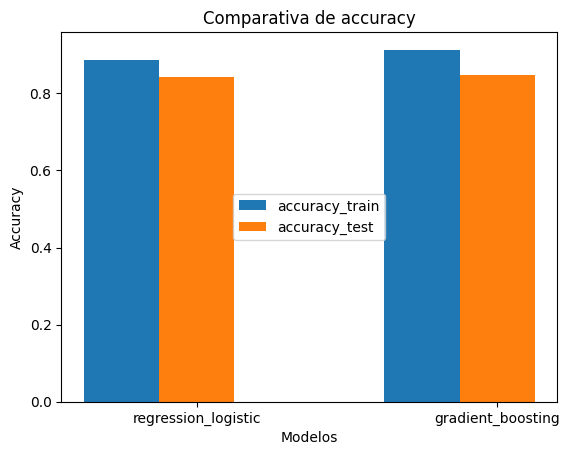

In [80]:
modelos = ['regression_logistic', 'gradient_boosting']
accuracy_train = [accuracy_train_lr, accuracy_train_gb]
accuracy_test = [accuracy_test_lr, accuracy_test_gb]

x = np.arange(len(modelos))
width = 0.25

fig, ax = plt.subplots()
ax.bar(x - width, accuracy_train, width, label = 'accuracy_train')
ax.bar(x , accuracy_test, width, label = 'accuracy_test')

ax.set_xlabel('Modelos')
ax.set_ylabel('Accuracy')
ax.set_title('Comparativa de accuracy')
ax.set_xticks(np.arange(len(modelos)), labels = modelos)
ax.legend(loc = 'center')

Podemos concluir que el modelo de Gradient Boosting clasifica mejor ya que tiene un mayor accuracy(91% sobre 88%) y la proporción de falsos positivos y falsos negativos es menor(8% sobre 11%).


**5. Predict**

Creamos una función para poder comparar la etiqueta del comentario con la predicción obtenida por el modelo.

In [25]:
import random
def predict_review_sentiment(review_index, model):
    print('Actual sentiment: {}'.format(data.iloc[review_index]['label']))
    r = data.iloc[review_index]['processed_text']
    print('Prediction: {}'.format(model.predict(cv.transform([r]))))

In [29]:
# Con gradient boosting
for i in random.sample(range(0, len(data)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, best_model)


Review no. 12163
Actual sentiment: 1
Prediction: [1]

Review no. 4551
Actual sentiment: 0
Prediction: [0]

Review no. 22247
Actual sentiment: 1
Prediction: [1]

Review no. 14959
Actual sentiment: 1
Prediction: [0]

Review no. 21279
Actual sentiment: 1
Prediction: [1]


In [30]:
# Con regresión logística
for i in random.sample(range(0, len(data)), 5):
    print('\nReview no. {}'.format(i))
    predict_review_sentiment(i, best_lr)


Review no. 1955
Actual sentiment: 0
Prediction: [0]

Review no. 7492
Actual sentiment: 0
Prediction: [0]

Review no. 5217
Actual sentiment: 0
Prediction: [0]

Review no. 7566
Actual sentiment: 0
Prediction: [1]

Review no. 6769
Actual sentiment: 0
Prediction: [0]


**6. Predicción de nuevos datos**

In [31]:
nombre_bucket_origen = 'ds-edw-processed-d1655b14'
nombre_bucket_procesado = 'ds-edw-processed-d1655b14'
nombre_blob_origen = 'CSV/new_processed.csv' # Aquí se pone el nombre de la carpeta CSV, barra / , y el nombre del csv con el que queremos trabajar
archivo_descarga_local = 'new_processed.csv' # Aquí se pone solamente el nombre del csv con el que queremos trabajar
descargar_de_bucket_origen(nombre_bucket_origen, nombre_blob_origen, archivo_descarga_local)

Archivo CSV/new_processed.csv descargado como new_processed.csv.


In [32]:
# Lectura de los nuevos datos
new_data = pd.read_csv(archivo_descarga_local)
new_data.head()

,Autor,new_processed
0,@slcuervo,si lo se con el ataque de mala hostia que me e...
1,@juanblanco2744,yapero lo mismo el k saques las matriculas es ...
2,@crikso1980,pero eso pasa en todos los sitiosno es nada es...
3,@ramoncillerofernandez6706,senor si la tarifa en el punto de recarga fues...
4,@josefasuarezsanchez8420,saul esto es espana no hay verguenza que valga


In [33]:
# Vectorizamos los nuevos comentarios para poder predecir su etiqueta
new_comments = new_data['new_processed']
new_comments_vectorizado = cv.transform(new_comments)

In [34]:
# Calculamos las predicciones con ambos modelos
y_lr = best_lr.predict(new_comments_vectorizado) # Con regresión logística
y_gb = best_model.predict(new_comments_vectorizado) # Con gradient boosting

In [37]:
# Creamos un dataframe los comentarios y sus etiquetas
new_df = pd.DataFrame({
    'comments': new_comments,
    'Logistic Regression': y_lr,
    'Gradient Boosting': y_gb
})
new_df.head()

,comments,Logistic Regression,Gradient Boosting
0,si lo se con el ataque de mala hostia que me e...,0,0
1,yapero lo mismo el k saques las matriculas es ...,1,0
2,pero eso pasa en todos los sitiosno es nada es...,0,0
3,senor si la tarifa en el punto de recarga fues...,0,0
4,saul esto es espana no hay verguenza que valga,1,0


In [38]:
# Guardamos los comentarios con sus etiquetas en un csv
new_df.to_csv('predict_comments.csv', index=False)

In [39]:
def subir_a_bucket_destino(nombre_bucket_procesado, nombre_archivo_destino, nombre_blob_destino):
    cliente = storage.Client()
    bucket = cliente.bucket(nombre_bucket_procesado)
    blob = bucket.blob(nombre_blob_destino)
    # Verificar si el archivo ya existe en el bucket
    if blob.exists():
        print(f"El archivo {nombre_blob_destino} ya existe en el bucket {nombre_bucket_procesado} y no se ha subido por no sobreescribirlo y preservar los datos, pon otro nombre o solicita ayuda al administrador del bucket.")
    else:
        blob.upload_from_filename(nombre_archivo_destino)
        print(f"Archivo {nombre_archivo_destino} subido a {nombre_blob_destino} en el bucket {nombre_bucket_procesado}.")

nombre_bucket_procesado = 'ds-edw-processed-d1655b14'
nombre_blob_destino = 'CSV/predict_comments.csv'
nombre_archivo_destino = 'predict_comments.csv'
subir_a_bucket_destino(nombre_bucket_procesado, nombre_archivo_destino, nombre_blob_destino)

Archivo predict_comments.csv subido a CSV/predict_comments.csv en el bucket ds-edw-processed-d1655b14.
